In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='75-5d'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/profiles-v2-pca-5d'

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV2,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV2, 
    PlotHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
PROFILES_DIR = os.path.join(DATASET_DIR, f'profiles-v2', f'profiles-v2-jsons')
INPUT_PT_PATH = f"/workspace/datasets/profiles-v2/profiles-v2-pca-5d/profiles-v2-pca-5-sample-{EXPERIMENT_NUM}.pt"
LABEL = f'profiles_v2_experiment_{EXPERIMENT_NUM}'

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/profiles-v2-pca-5d/profiles_v2_experiment_75-5d_20250803_0226


In [3]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = torch.load(INPUT_PT_PATH)

Saved figure to /workspace/profiles-v2-pca-5d/profiles_v2_experiment_75-5d_20250803_0226/density_plot.png


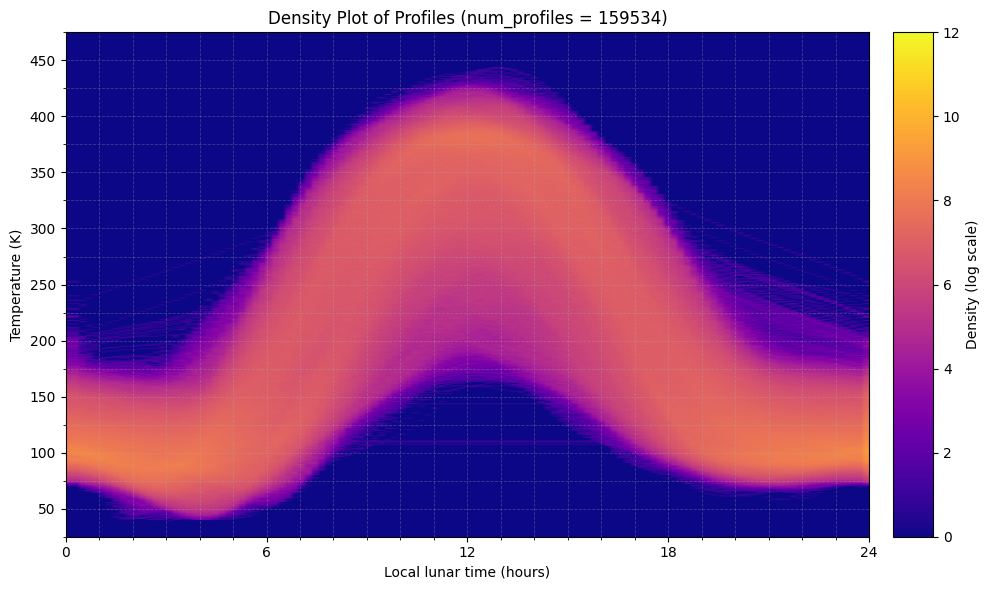

In [4]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [5]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 196.4150
STD: 98.0659
Min Temp: 40.0240
Max Temp: 443.4440
Datasets:
Training Data: 111673
Validation Data: 31906
Test Data: 15955


In [6]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

[Training] Epoch 1/100: 100%|██████████| 559/559 [00:18<00:00, 29.89it/s, best_loss=0.8803]


[Training] Epoch 1/100, L1 Loss: 0.8169, L2 Loss: 1.0003, KL Loss: 0.0037, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 160/160 [00:01<00:00, 99.04it/s] 


[Validation] Epoch 1/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001
[Validation] Saved checkpoint in '/workspace/profiles-v2-pca-5d/profiles_v2_experiment_75-5d_20250803_0226'


[Training] Epoch 2/100: 100%|██████████| 559/559 [00:18<00:00, 29.66it/s, best_loss=0.8694]


[Training] Epoch 2/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 160/160 [00:01<00:00, 91.52it/s]


[Validation] Epoch 2/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 3/100: 100%|██████████| 559/559 [00:18<00:00, 30.01it/s, best_loss=0.8754]


[Training] Epoch 3/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 160/160 [00:01<00:00, 95.56it/s]


[Validation] Epoch 3/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 4/100: 100%|██████████| 559/559 [00:18<00:00, 29.64it/s, best_loss=0.8810]


[Training] Epoch 4/100, L1 Loss: 0.8168, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 160/160 [00:01<00:00, 98.27it/s]


[Validation] Epoch 4/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 5/100: 100%|██████████| 559/559 [00:19<00:00, 29.08it/s, best_loss=0.8652]


[Training] Epoch 5/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 160/160 [00:01<00:00, 97.55it/s]


[Validation] Epoch 5/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 6/100: 100%|██████████| 559/559 [00:18<00:00, 29.68it/s, best_loss=0.8944]


[Training] Epoch 6/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 160/160 [00:01<00:00, 100.91it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 7/100: 100%|██████████| 559/559 [00:18<00:00, 30.17it/s, best_loss=0.8744]


[Training] Epoch 7/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 160/160 [00:01<00:00, 108.74it/s]


[Validation] Epoch 7/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 8/100: 100%|██████████| 559/559 [00:18<00:00, 29.55it/s, best_loss=0.8694]


[Training] Epoch 8/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 160/160 [00:01<00:00, 99.97it/s] 


[Validation] Epoch 8/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 9/100: 100%|██████████| 559/559 [00:18<00:00, 30.36it/s, best_loss=0.8704]


[Training] Epoch 9/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 160/160 [00:01<00:00, 97.58it/s] 


[Validation] Epoch 9/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 10/100: 100%|██████████| 559/559 [00:18<00:00, 30.04it/s, best_loss=0.8837]


[Training] Epoch 10/100, L1 Loss: 0.8168, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 160/160 [00:01<00:00, 102.12it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 11/100: 100%|██████████| 559/559 [00:18<00:00, 29.79it/s, best_loss=0.8639]


[Training] Epoch 11/100, L1 Loss: 0.8168, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 160/160 [00:01<00:00, 96.40it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 12/100: 100%|██████████| 559/559 [00:18<00:00, 29.99it/s, best_loss=0.8824]


[Training] Epoch 12/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 160/160 [00:01<00:00, 96.21it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 13/100: 100%|██████████| 559/559 [00:18<00:00, 29.98it/s, best_loss=0.8561]


[Training] Epoch 13/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 160/160 [00:01<00:00, 94.49it/s]


[Validation] Epoch 13/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 14/100: 100%|██████████| 559/559 [00:18<00:00, 30.12it/s, best_loss=0.8722]


[Training] Epoch 14/100, L1 Loss: 0.8168, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 160/160 [00:01<00:00, 98.37it/s] 


[Validation] Epoch 14/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 15/100: 100%|██████████| 559/559 [00:18<00:00, 30.36it/s, best_loss=0.8514]


[Training] Epoch 15/100, L1 Loss: 0.8168, L2 Loss: 1.0002, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 160/160 [00:01<00:00, 107.81it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 16/100: 100%|██████████| 559/559 [00:18<00:00, 30.92it/s, best_loss=0.8717]


[Training] Epoch 16/100, L1 Loss: 0.8168, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 160/160 [00:01<00:00, 103.22it/s]


[Validation] Epoch 16/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 17/100: 100%|██████████| 559/559 [00:18<00:00, 30.88it/s, best_loss=0.9034]


[Training] Epoch 17/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 160/160 [00:01<00:00, 114.42it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 18/100: 100%|██████████| 559/559 [00:17<00:00, 31.34it/s, best_loss=0.8916]


[Training] Epoch 18/100, L1 Loss: 0.8168, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 160/160 [00:01<00:00, 103.12it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 19/100: 100%|██████████| 559/559 [00:18<00:00, 30.88it/s, best_loss=0.8739]


[Training] Epoch 19/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 160/160 [00:01<00:00, 107.65it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 20/100: 100%|██████████| 559/559 [00:18<00:00, 30.45it/s, best_loss=0.8720]


[Training] Epoch 20/100, L1 Loss: 0.8168, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 160/160 [00:01<00:00, 102.67it/s]


[Validation] Epoch 20/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 21/100: 100%|██████████| 559/559 [00:18<00:00, 30.31it/s, best_loss=0.8884]


[Training] Epoch 21/100, L1 Loss: 0.8168, L2 Loss: 1.0002, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 160/160 [00:01<00:00, 97.68it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 22/100: 100%|██████████| 559/559 [00:18<00:00, 30.48it/s, best_loss=0.8810]


[Training] Epoch 22/100, L1 Loss: 0.8168, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 160/160 [00:01<00:00, 95.69it/s] 


[Validation] Epoch 22/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 23/100: 100%|██████████| 559/559 [00:18<00:00, 30.82it/s, best_loss=0.8652]


[Training] Epoch 23/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 160/160 [00:01<00:00, 96.77it/s]


[Validation] Epoch 23/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 24/100: 100%|██████████| 559/559 [00:18<00:00, 30.93it/s, best_loss=0.8766]


[Training] Epoch 24/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 160/160 [00:01<00:00, 107.40it/s]


[Validation] Epoch 24/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 25/100: 100%|██████████| 559/559 [00:18<00:00, 30.92it/s, best_loss=0.8622]


[Training] Epoch 25/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 160/160 [00:01<00:00, 107.36it/s]


[Validation] Epoch 25/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 26/100: 100%|██████████| 559/559 [00:18<00:00, 30.50it/s, best_loss=0.8844]


[Training] Epoch 26/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 160/160 [00:01<00:00, 98.79it/s] 


[Validation] Epoch 26/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 27/100: 100%|██████████| 559/559 [00:18<00:00, 30.50it/s, best_loss=0.8794]


[Training] Epoch 27/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 160/160 [00:01<00:00, 109.00it/s]


[Validation] Epoch 27/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 28/100: 100%|██████████| 559/559 [00:18<00:00, 30.46it/s, best_loss=0.8824]


[Training] Epoch 28/100, L1 Loss: 0.8168, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 160/160 [00:01<00:00, 99.24it/s] 


[Validation] Epoch 28/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 29/100: 100%|██████████| 559/559 [00:18<00:00, 30.01it/s, best_loss=0.8576]


[Training] Epoch 29/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 160/160 [00:01<00:00, 102.88it/s]


[Validation] Epoch 29/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 30/100: 100%|██████████| 559/559 [00:18<00:00, 30.03it/s, best_loss=0.8752]


[Training] Epoch 30/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 160/160 [00:01<00:00, 98.77it/s] 


[Validation] Epoch 30/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 31/100: 100%|██████████| 559/559 [00:18<00:00, 29.82it/s, best_loss=0.8687]


[Training] Epoch 31/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 160/160 [00:01<00:00, 94.32it/s]


[Validation] Epoch 31/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 32/100: 100%|██████████| 559/559 [00:18<00:00, 29.69it/s, best_loss=0.8602]


[Training] Epoch 32/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 160/160 [00:01<00:00, 98.78it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 33/100: 100%|██████████| 559/559 [00:18<00:00, 29.87it/s, best_loss=0.8622]


[Training] Epoch 33/100, L1 Loss: 0.8168, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 160/160 [00:01<00:00, 98.98it/s] 


[Validation] Epoch 33/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 34/100: 100%|██████████| 559/559 [00:18<00:00, 30.73it/s, best_loss=0.8778]


[Training] Epoch 34/100, L1 Loss: 0.8168, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 160/160 [00:01<00:00, 105.05it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 35/100: 100%|██████████| 559/559 [00:18<00:00, 30.26it/s, best_loss=0.8703]


[Training] Epoch 35/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 160/160 [00:01<00:00, 107.35it/s]


[Validation] Epoch 35/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 36/100: 100%|██████████| 559/559 [00:18<00:00, 30.03it/s, best_loss=0.8767]


[Training] Epoch 36/100, L1 Loss: 0.8168, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 160/160 [00:01<00:00, 103.76it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 37/100: 100%|██████████| 559/559 [00:18<00:00, 29.95it/s, best_loss=0.8747]


[Training] Epoch 37/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 160/160 [00:01<00:00, 101.71it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 38/100: 100%|██████████| 559/559 [00:18<00:00, 29.82it/s, best_loss=0.8601]


[Training] Epoch 38/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 160/160 [00:01<00:00, 104.97it/s]


[Validation] Epoch 38/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 39/100: 100%|██████████| 559/559 [00:18<00:00, 30.12it/s, best_loss=0.8612]


[Training] Epoch 39/100, L1 Loss: 0.8167, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 160/160 [00:01<00:00, 96.13it/s] 


[Validation] Epoch 39/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 40/100: 100%|██████████| 559/559 [00:18<00:00, 30.16it/s, best_loss=0.8616]


[Training] Epoch 40/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 160/160 [00:01<00:00, 101.92it/s]


[Validation] Epoch 40/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 41/100: 100%|██████████| 559/559 [00:19<00:00, 29.42it/s, best_loss=0.8868]


[Training] Epoch 41/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 160/160 [00:01<00:00, 101.58it/s]


[Validation] Epoch 41/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 42/100: 100%|██████████| 559/559 [00:18<00:00, 30.56it/s, best_loss=0.8607]


[Training] Epoch 42/100, L1 Loss: 0.8168, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 160/160 [00:01<00:00, 100.60it/s]


[Validation] Epoch 42/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 43/100: 100%|██████████| 559/559 [00:18<00:00, 30.38it/s, best_loss=0.8669]


[Training] Epoch 43/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 160/160 [00:01<00:00, 108.01it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 44/100: 100%|██████████| 559/559 [00:18<00:00, 30.12it/s, best_loss=0.8866]


[Training] Epoch 44/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 160/160 [00:01<00:00, 100.98it/s]


[Validation] Epoch 44/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 45/100: 100%|██████████| 559/559 [00:18<00:00, 29.74it/s, best_loss=0.8754]


[Training] Epoch 45/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 160/160 [00:01<00:00, 98.25it/s] 


[Validation] Epoch 45/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 46/100: 100%|██████████| 559/559 [00:18<00:00, 29.76it/s, best_loss=0.8846]


[Training] Epoch 46/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 160/160 [00:01<00:00, 100.91it/s]


[Validation] Epoch 46/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 47/100: 100%|██████████| 559/559 [00:19<00:00, 28.38it/s, best_loss=0.8750]


[Training] Epoch 47/100, L1 Loss: 0.8168, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 160/160 [00:01<00:00, 98.13it/s] 


[Validation] Epoch 47/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 48/100: 100%|██████████| 559/559 [00:19<00:00, 28.44it/s, best_loss=0.8698]


[Training] Epoch 48/100, L1 Loss: 0.8168, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 160/160 [00:01<00:00, 105.66it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 49/100: 100%|██████████| 559/559 [00:18<00:00, 30.36it/s, best_loss=0.8955]


[Training] Epoch 49/100, L1 Loss: 0.8168, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 160/160 [00:01<00:00, 105.74it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 50/100: 100%|██████████| 559/559 [00:18<00:00, 30.50it/s, best_loss=0.8623]


[Training] Epoch 50/100, L1 Loss: 0.8168, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 160/160 [00:01<00:00, 105.70it/s]


[Validation] Epoch 50/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 51/100: 100%|██████████| 559/559 [00:18<00:00, 30.17it/s, best_loss=0.8711]


[Training] Epoch 51/100, L1 Loss: 0.8168, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 160/160 [00:01<00:00, 105.36it/s]


[Validation] Epoch 51/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 52/100: 100%|██████████| 559/559 [00:18<00:00, 30.04it/s, best_loss=0.8758]


[Training] Epoch 52/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 160/160 [00:01<00:00, 98.76it/s]


[Validation] Epoch 52/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 53/100: 100%|██████████| 559/559 [00:18<00:00, 29.90it/s, best_loss=0.8742]


[Training] Epoch 53/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 160/160 [00:01<00:00, 102.45it/s]


[Validation] Epoch 53/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 54/100: 100%|██████████| 559/559 [00:18<00:00, 30.32it/s, best_loss=0.8775]


[Training] Epoch 54/100, L1 Loss: 0.8168, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 160/160 [00:01<00:00, 103.02it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 55/100: 100%|██████████| 559/559 [00:18<00:00, 29.99it/s, best_loss=0.8946]


[Training] Epoch 55/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 160/160 [00:01<00:00, 101.61it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 56/100: 100%|██████████| 559/559 [00:18<00:00, 30.05it/s, best_loss=0.8607]


[Training] Epoch 56/100, L1 Loss: 0.8167, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 160/160 [00:01<00:00, 100.79it/s]


[Validation] Epoch 56/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 57/100: 100%|██████████| 559/559 [00:18<00:00, 30.33it/s, best_loss=0.8875]


[Training] Epoch 57/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 160/160 [00:01<00:00, 96.60it/s]


[Validation] Epoch 57/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 58/100: 100%|██████████| 559/559 [00:18<00:00, 29.54it/s, best_loss=0.8667]


[Training] Epoch 58/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 160/160 [00:01<00:00, 100.20it/s]


[Validation] Epoch 58/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 59/100: 100%|██████████| 559/559 [00:18<00:00, 29.64it/s, best_loss=0.8759]


[Training] Epoch 59/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 160/160 [00:01<00:00, 97.79it/s] 


[Validation] Epoch 59/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 60/100: 100%|██████████| 559/559 [00:18<00:00, 30.20it/s, best_loss=0.8892]


[Training] Epoch 60/100, L1 Loss: 0.8168, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 160/160 [00:01<00:00, 95.65it/s] 


[Validation] Epoch 60/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 61/100: 100%|██████████| 559/559 [00:18<00:00, 30.11it/s, best_loss=0.8576]


[Training] Epoch 61/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 160/160 [00:01<00:00, 94.26it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 62/100: 100%|██████████| 559/559 [00:18<00:00, 29.88it/s, best_loss=0.8685]


[Training] Epoch 62/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 160/160 [00:01<00:00, 100.89it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 63/100: 100%|██████████| 559/559 [00:18<00:00, 30.49it/s, best_loss=0.8947]


[Training] Epoch 63/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 160/160 [00:01<00:00, 101.84it/s]


[Validation] Epoch 63/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 64/100: 100%|██████████| 559/559 [00:18<00:00, 30.59it/s, best_loss=0.8667]


[Training] Epoch 64/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 160/160 [00:01<00:00, 96.12it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 65/100: 100%|██████████| 559/559 [00:18<00:00, 29.98it/s, best_loss=0.8587]


[Training] Epoch 65/100, L1 Loss: 0.8168, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 160/160 [00:01<00:00, 101.18it/s]


[Validation] Epoch 65/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 66/100: 100%|██████████| 559/559 [00:19<00:00, 29.32it/s, best_loss=0.8410]


[Training] Epoch 66/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 160/160 [00:01<00:00, 105.24it/s]


[Validation] Epoch 66/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 67/100: 100%|██████████| 559/559 [00:18<00:00, 30.12it/s, best_loss=0.8690]


[Training] Epoch 67/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 160/160 [00:01<00:00, 103.10it/s]


[Validation] Epoch 67/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 68/100: 100%|██████████| 559/559 [00:18<00:00, 29.94it/s, best_loss=0.8706]


[Training] Epoch 68/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 160/160 [00:01<00:00, 100.96it/s]


[Validation] Epoch 68/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 69/100: 100%|██████████| 559/559 [00:18<00:00, 30.32it/s, best_loss=0.8673]


[Training] Epoch 69/100, L1 Loss: 0.8167, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 160/160 [00:01<00:00, 96.72it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 70/100: 100%|██████████| 559/559 [00:19<00:00, 29.21it/s, best_loss=0.8309]


[Training] Epoch 70/100, L1 Loss: 0.8168, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 160/160 [00:01<00:00, 93.15it/s]


[Validation] Epoch 70/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 71/100: 100%|██████████| 559/559 [00:18<00:00, 29.44it/s, best_loss=0.8887]


[Training] Epoch 71/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 160/160 [00:01<00:00, 97.54it/s] 


[Validation] Epoch 71/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 72/100: 100%|██████████| 559/559 [00:18<00:00, 29.80it/s, best_loss=0.8858]


[Training] Epoch 72/100, L1 Loss: 0.8168, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 160/160 [00:01<00:00, 96.59it/s]


[Validation] Epoch 72/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 73/100: 100%|██████████| 559/559 [00:18<00:00, 29.60it/s, best_loss=0.8965]


[Training] Epoch 73/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 160/160 [00:01<00:00, 94.48it/s]


[Validation] Epoch 73/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 74/100: 100%|██████████| 559/559 [00:18<00:00, 29.82it/s, best_loss=0.8743]


[Training] Epoch 74/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 160/160 [00:01<00:00, 99.33it/s] 


[Validation] Epoch 74/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 75/100: 100%|██████████| 559/559 [00:19<00:00, 29.37it/s, best_loss=0.8647]


[Training] Epoch 75/100, L1 Loss: 0.8168, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 160/160 [00:01<00:00, 103.21it/s]


[Validation] Epoch 75/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 76/100: 100%|██████████| 559/559 [00:18<00:00, 30.15it/s, best_loss=0.8800]


[Training] Epoch 76/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 160/160 [00:01<00:00, 105.72it/s]


[Validation] Epoch 76/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 77/100: 100%|██████████| 559/559 [00:18<00:00, 29.68it/s, best_loss=0.8794]


[Training] Epoch 77/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 160/160 [00:01<00:00, 104.40it/s]


[Validation] Epoch 77/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 78/100: 100%|██████████| 559/559 [00:18<00:00, 30.21it/s, best_loss=0.8819]


[Training] Epoch 78/100, L1 Loss: 0.8168, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 160/160 [00:01<00:00, 96.96it/s]


[Validation] Epoch 78/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 79/100: 100%|██████████| 559/559 [00:18<00:00, 29.51it/s, best_loss=0.8208]


[Training] Epoch 79/100, L1 Loss: 0.8167, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 160/160 [00:01<00:00, 100.20it/s]


[Validation] Epoch 79/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 80/100: 100%|██████████| 559/559 [00:19<00:00, 28.45it/s, best_loss=0.8873]


[Training] Epoch 80/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 160/160 [00:01<00:00, 100.91it/s]


[Validation] Epoch 80/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 81/100: 100%|██████████| 559/559 [00:19<00:00, 28.95it/s, best_loss=0.8776]


[Training] Epoch 81/100, L1 Loss: 0.8168, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 160/160 [00:01<00:00, 102.73it/s]


[Validation] Epoch 81/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 82/100: 100%|██████████| 559/559 [00:18<00:00, 29.44it/s, best_loss=0.8884]


[Training] Epoch 82/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 160/160 [00:01<00:00, 104.49it/s]


[Validation] Epoch 82/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 83/100: 100%|██████████| 559/559 [00:18<00:00, 29.78it/s, best_loss=0.8741]


[Training] Epoch 83/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 160/160 [00:01<00:00, 99.80it/s] 


[Validation] Epoch 83/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 84/100: 100%|██████████| 559/559 [00:19<00:00, 29.30it/s, best_loss=0.8787]


[Training] Epoch 84/100, L1 Loss: 0.8168, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 160/160 [00:01<00:00, 90.78it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 85/100: 100%|██████████| 559/559 [00:18<00:00, 29.60it/s, best_loss=0.8693]


[Training] Epoch 85/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 160/160 [00:01<00:00, 99.72it/s] 


[Validation] Epoch 85/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 86/100: 100%|██████████| 559/559 [00:19<00:00, 29.03it/s, best_loss=0.8569]


[Training] Epoch 86/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 160/160 [00:01<00:00, 96.89it/s]


[Validation] Epoch 86/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 87/100: 100%|██████████| 559/559 [00:18<00:00, 29.48it/s, best_loss=0.8629]


[Training] Epoch 87/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 160/160 [00:01<00:00, 98.27it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 88/100: 100%|██████████| 559/559 [00:19<00:00, 28.89it/s, best_loss=0.8798]


[Training] Epoch 88/100, L1 Loss: 0.8168, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 160/160 [00:01<00:00, 98.69it/s] 


[Validation] Epoch 88/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 89/100: 100%|██████████| 559/559 [00:18<00:00, 29.43it/s, best_loss=0.8735]


[Training] Epoch 89/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 160/160 [00:01<00:00, 95.60it/s]


[Validation] Epoch 89/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 90/100: 100%|██████████| 559/559 [00:19<00:00, 29.10it/s, best_loss=0.8699]


[Training] Epoch 90/100, L1 Loss: 0.8168, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 160/160 [00:01<00:00, 96.54it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 91/100: 100%|██████████| 559/559 [00:19<00:00, 28.09it/s, best_loss=0.8568]


[Training] Epoch 91/100, L1 Loss: 0.8168, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 160/160 [00:01<00:00, 93.90it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 92/100: 100%|██████████| 559/559 [00:19<00:00, 28.79it/s, best_loss=0.8685]


[Training] Epoch 92/100, L1 Loss: 0.8168, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 160/160 [00:01<00:00, 98.06it/s] 


[Validation] Epoch 92/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 93/100: 100%|██████████| 559/559 [00:19<00:00, 29.38it/s, best_loss=0.8720]


[Training] Epoch 93/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 160/160 [00:01<00:00, 96.35it/s] 


[Validation] Epoch 93/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 94/100: 100%|██████████| 559/559 [00:19<00:00, 28.89it/s, best_loss=0.8723]


[Training] Epoch 94/100, L1 Loss: 0.8168, L2 Loss: 1.0002, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 160/160 [00:01<00:00, 94.64it/s]


[Validation] Epoch 94/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 95/100: 100%|██████████| 559/559 [00:18<00:00, 29.47it/s, best_loss=0.8839]


[Training] Epoch 95/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 160/160 [00:01<00:00, 96.90it/s] 


[Validation] Epoch 95/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 96/100: 100%|██████████| 559/559 [00:19<00:00, 29.28it/s, best_loss=0.8629]


[Training] Epoch 96/100, L1 Loss: 0.8167, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 160/160 [00:01<00:00, 96.76it/s]


[Validation] Epoch 96/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 97/100: 100%|██████████| 559/559 [00:19<00:00, 28.72it/s, best_loss=0.8852]


[Training] Epoch 97/100, L1 Loss: 0.8167, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 160/160 [00:01<00:00, 94.87it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 98/100: 100%|██████████| 559/559 [00:19<00:00, 29.10it/s, best_loss=0.8541]


[Training] Epoch 98/100, L1 Loss: 0.8168, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 160/160 [00:01<00:00, 97.34it/s]


[Validation] Epoch 98/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 99/100: 100%|██████████| 559/559 [00:19<00:00, 28.93it/s, best_loss=0.8639]


[Training] Epoch 99/100, L1 Loss: 0.8168, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 160/160 [00:01<00:00, 98.19it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


[Training] Epoch 100/100: 100%|██████████| 559/559 [00:18<00:00, 29.44it/s, best_loss=0.8900]


[Training] Epoch 100/100, L1 Loss: 0.8168, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 160/160 [00:01<00:00, 98.37it/s] 


[Validation] Epoch 100/100, Val L1 Loss: 0.8191, Val L2 Loss: 1.0051, Val KL Loss: 0.0001


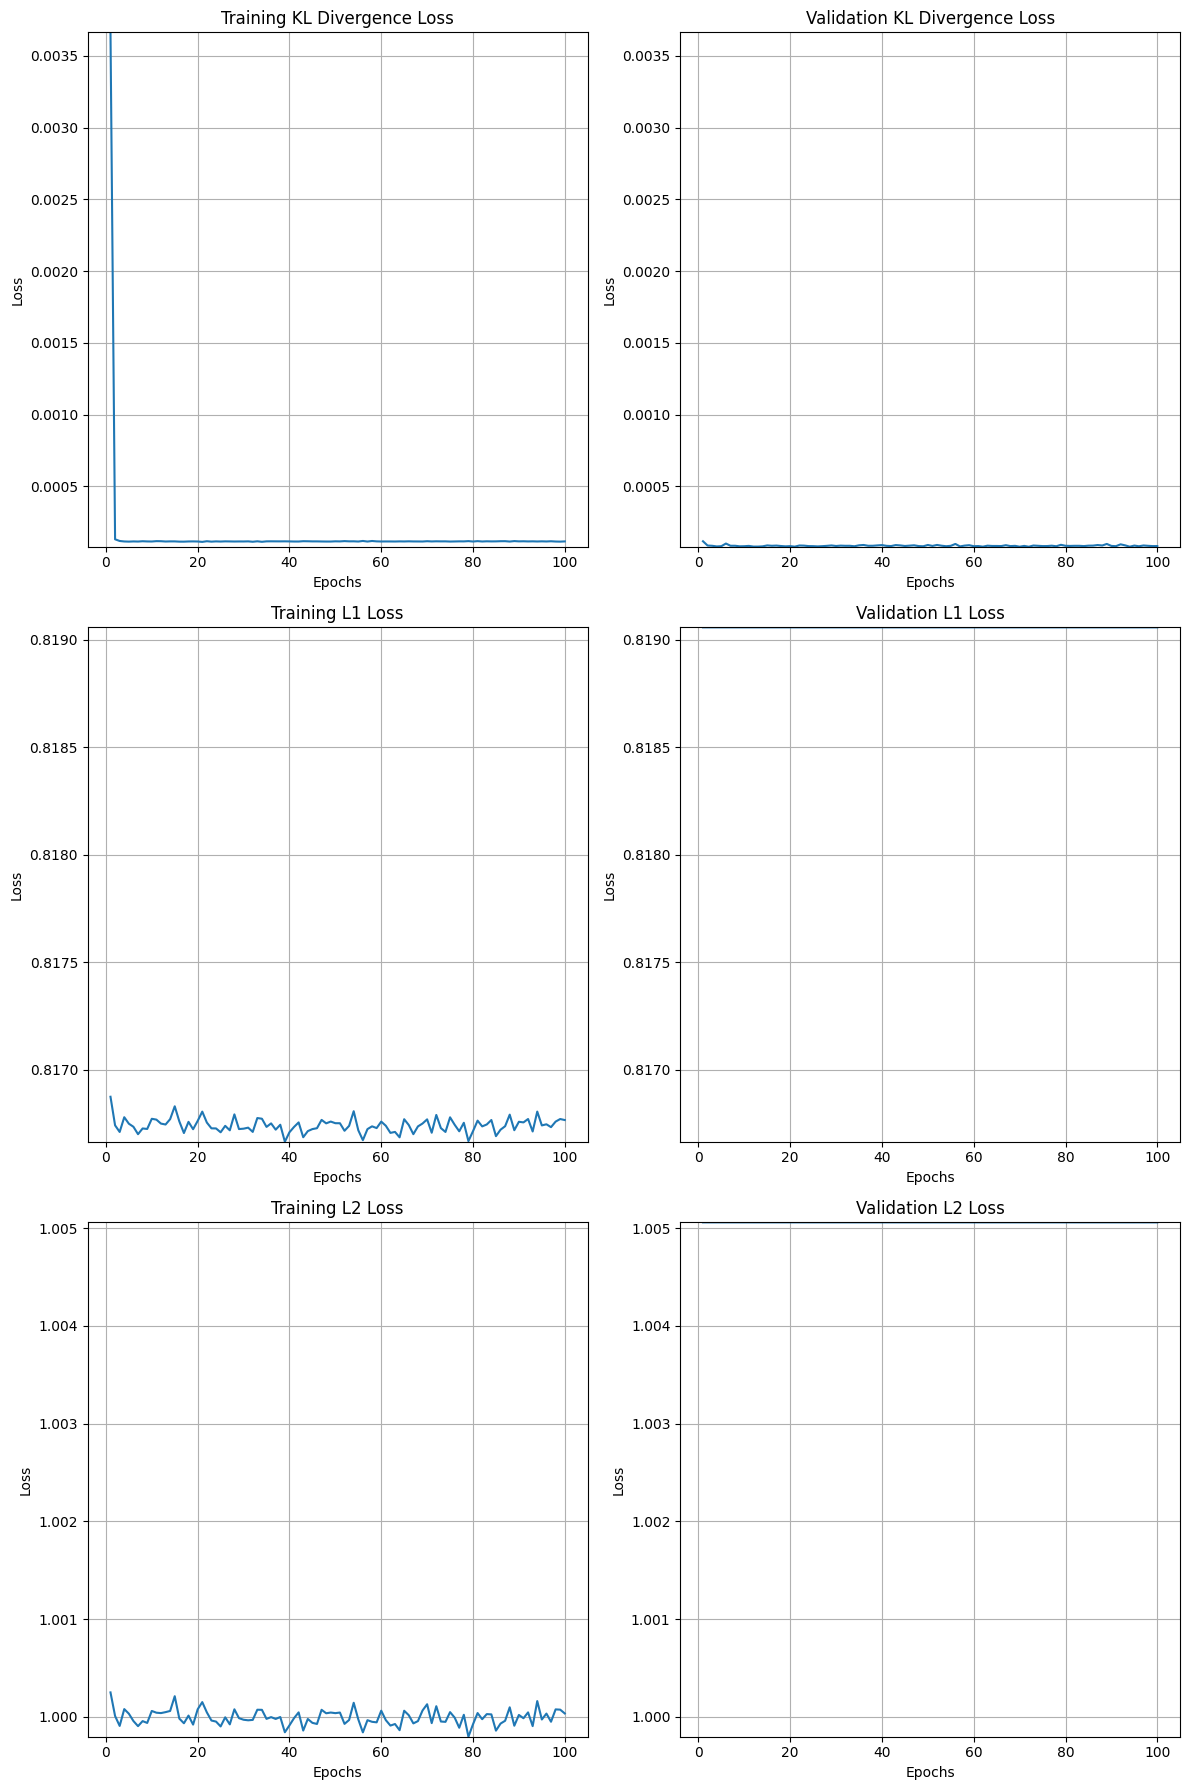

Best Validation Loss in Kelvins:
80.3216 K


In [7]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

# Plot losses
PlotLosses(losses, EPOCHS, model_dir)

# Save losses
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

In [8]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


z0: -0.0003
z1: 0.0003
z2: -0.0009
z3: -0.0001


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 695.75it/s]


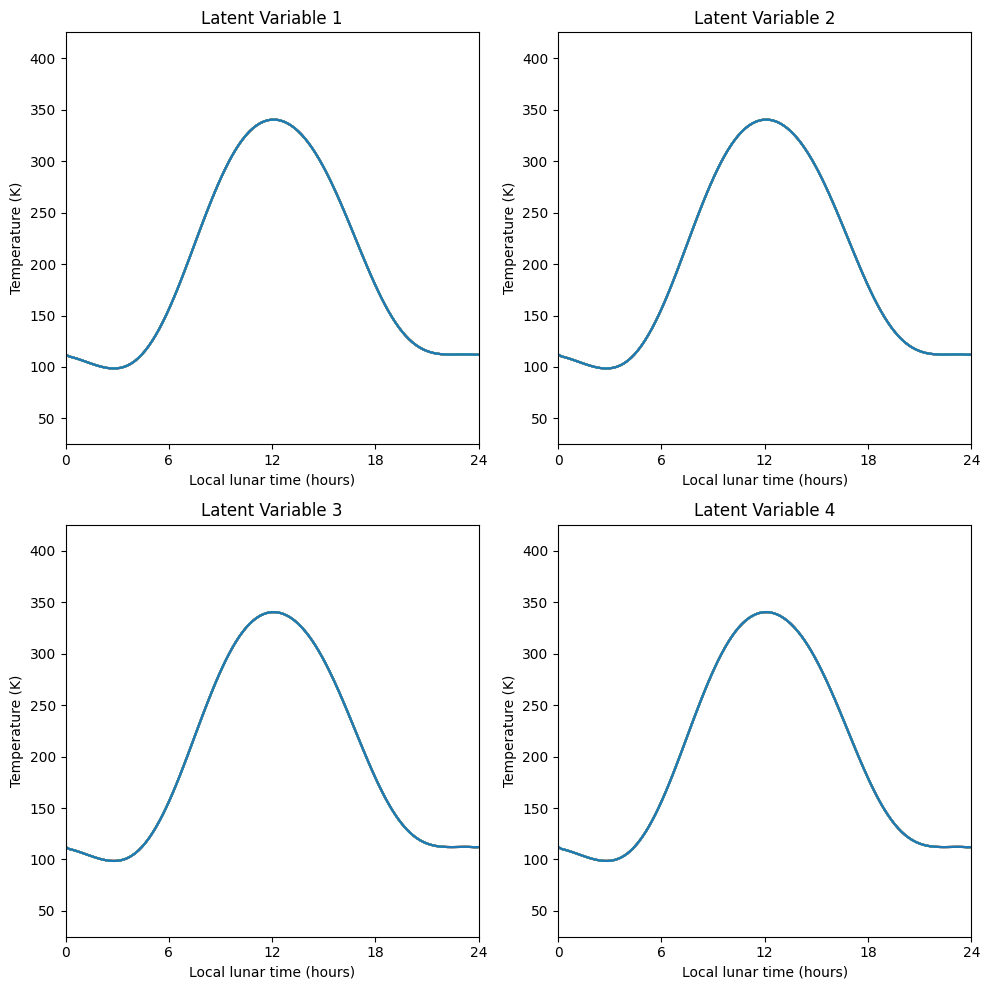

In [9]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)